## Load the matplotlib magic and the normal pandas stack

In [10]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot
import os
import re

## here we'll set the matplotlib figure size to take up more real estate
pyplot.rcParams['figure.figsize'] = [12, 5]

## Read the data into a set of DataFrames

In [11]:
outputFiles = os.listdir('./output')
output_series = (list(), list())
output_metrics = (list(), list())
inputs = (list(), list())
for outputFile in outputFiles:
    simName = outputFile[:outputFile.index('.output')]
    with open("./output/" + outputFile, 'r') as f:
        for cnt, line in enumerate(f):
            split = line.split()
            if len(split) > 1:
                if split[0].startswith('OUT'):
                    measure = split[0][:split[0].rfind('_')]
                    iteration = int(split[0][split[0].rfind('_')+1:])
                    if len(split) > 2:
                        output_series[0].append((simName, measure, iteration))
                        output_series[1].append(pd.Series(split[1:]).astype(float))
                    else:
                        output_metrics[0].append((simName, measure, iteration))
                        output_metrics[1].append(float(split[1]))
                        
                if split[0].startswith('INP'):
                    inputs[0].append((simName, split[0]))
                    inputs[1].append(float(split[1]))
                                   
series_index = pd.MultiIndex.from_tuples(output_series[0], names=['simulation', 'measure', 'iteration'])
series = pd.DataFrame(pd.Series(output_series[1], index=series_index), columns=['values'])

metrics_index = pd.MultiIndex.from_tuples(output_metrics[0], names=['simulation', 'measure', 'iteration'])
metrics = pd.DataFrame(pd.Series(output_metrics[1], index=metrics_index), columns=['values'])

inputs_index = pd.MultiIndex.from_tuples(inputs[0], names=['simulation', 'measure'])
inputs = pd.DataFrame(pd.Series(inputs[1], index=inputs_index), columns=['values'])


## Great, lets take a look at the data! We'll look at the 1000 customer / 10 cashier scenario and create a histogram of the customer shop times.

count    1000.000000
mean       14.686797
std         7.608408
min         2.531300
25%         9.348450
50%        13.143150
75%        18.138250
max        64.067000
dtype: float64

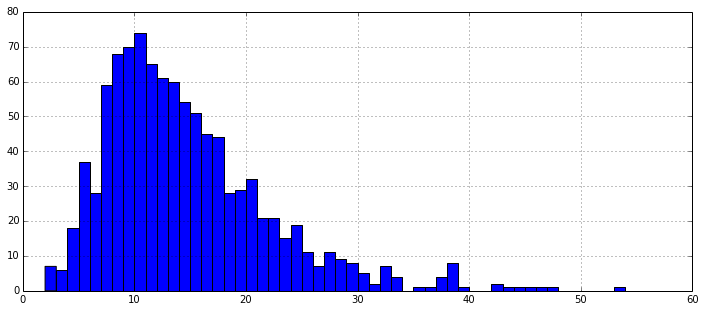

In [12]:
shopTimes = series['values']['cashier_1000_10']['OUT_CUSTOMER_SHOP_TIMES'][0]
_, division = np.histogram(shopTimes, range(int(shopTimes.min()),int(shopTimes.max()),1))
shopTimes.hist(bins=division)
shopTimes.describe()

## We can see it is a lognormal distribution, with a mean of around 15 minutes and a standard deviation of ~8 minutes. That matches up with our input.

## Lets take a look at some entry times.

count    1000.000000
mean      118.420553
std        58.269421
min        21.305200
25%        77.544925
50%       108.299050
75%       147.179125
max       600.071100
dtype: float64

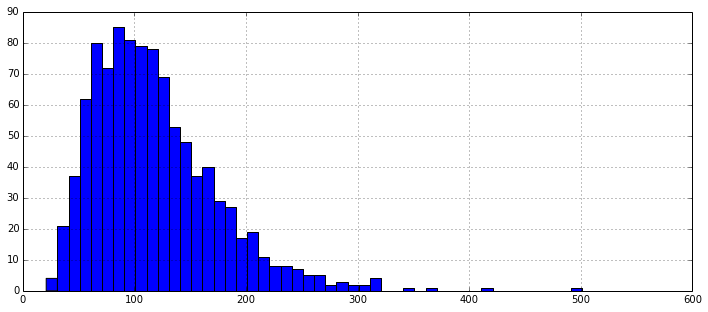

In [13]:
entryTimes = series['values']['cashier_1000_10']['OUT_CUSTOMER_ENTRY_TIMES'][0]
count, division = np.histogram(entryTimes, range(int(entryTimes.min()),int(entryTimes.max()),10))
entryTimes.hist(bins=division)
entryTimes.describe()

## Again, a lognormal distribution. A mean of 120 minutes with a standard deviation of ~ an hour. So far, so good. Lets take a look at the customer wait times

In [14]:
series['values']['cashier_1000_10']['OUT_CUSTOMER_WAIT_TIMES'].apply(lambda x: x.describe())

,count,mean,std,min,25%,50%,75%,max
iteration,,,,,,,,
1,1000.0,0.050518,0.114125,0.0,0.000000,0.00000,0.024725,0.7032
2,1000.0,26.932418,17.966520,0.0,9.313400,29.96250,45.126850,50.3651
4,1000.0,22.838178,15.550098,0.0,7.176850,25.45470,37.599700,44.2812
0,1000.0,42.927516,27.160781,0.0,16.889700,46.32100,69.843825,78.8327
6,1000.0,1.880609,2.199346,0.0,0.000000,0.54820,3.878850,6.3261
7,1000.0,0.205208,0.438877,0.0,0.000000,0.00000,0.172625,2.1121
5,1000.0,66.772821,39.709976,0.0,29.878375,72.97010,104.767225,118.2449
8,1000.0,23.953546,16.850973,0.0,6.236900,26.23995,40.684750,46.4514
9,1000.0,83.300528,49.204053,0.0,38.482775,88.94710,132.234075,145.3820


## Wow, look at those wait times. There is only one iteration that has a mean wait time < 1 hour. 
---
## Lets broaden our view. We'll count the iterations for each simulation that has a mean wait time of < 15 minutes.

In [15]:
series = series.reset_index()
series.set_index(['measure', 'simulation', 'iteration'], inplace=True)
df = pd.DataFrame(series['values']['OUT_CUSTOMER_WAIT_TIMES'].apply(lambda x: x.mean()))
df.loc[df['values'] < 15].groupby(['simulation']).count()

,values
simulation,
cashier_1000_10,4
cashier_1000_11,6
cashier_1000_12,3
cashier_1000_13,8
cashier_1000_14,7
cashier_1000_15,10
cashier_1000_16,10
cashier_1000_17,10


## This gives us a good idea of where to start. Lets look at simulations of 13-17 cashiers, but this time, we'll run a years worth of iterations.